In [29]:
import os
import requests
import sqlite3
import pickle
from datetime import datetime, timedelta
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from dotenv import load_dotenv
from IPython.display import clear_output
import util
import strategies
from importlib import reload
load_dotenv()
reload(util)

<module 'util' from 'c:\\Users\\joshu\\Documents\\Github\\Trading-Bot\\Uncon Backtest\\util.py'>

In [4]:

kraken_coin_data = util.get_exchange_coins('kraken')
kraken_coin_ids = [coin['coin_id'] for coin in kraken_coin_data]
kraken_symbols = [coin['base'].lower() for coin in kraken_coin_data]
tradable_kraken_coins = util.get_tradable_kraken_coins()
all_data = util.get_all_ochl()

kraken_data = all_data[all_data['coin_id'].isin(kraken_coin_ids)]
coins_to_exclude = [
        'tether', 
        'usd-coin', 
        'true-usd', 
        'wrapped-bitcoin',
        'dai',
        'terra-luna',
        'ftx-token',
        'bora',
        'theta-fuel',
        'gifto',
        'amber',
        'cocos-bcx',
        'beldex',
        'usdc',
    ]
exclude_coins_symbol = [coin['base'].lower() for coin in kraken_coin_data if coin['coin_id'] in coins_to_exclude]
all_close_prices = util.get_col_pivot_from_all_ochl(type ='close',volume_threshold= 100000)
all_high_prices = util.get_col_pivot_from_all_ochl(type ='high', volume_threshold=100000)
all_low_prices = util.get_col_pivot_from_all_ochl(type ='low', volume_threshold=100000)
all_vol = util.get_col_pivot_from_all_ochl(type='volume' ,volume_threshold=100000)
kraken_columns = list(set(all_close_prices.columns).intersection(set(kraken_symbols))-set(exclude_coins_symbol))
all_kraken_close_prices = np.log(all_close_prices[kraken_columns])
all_kraken_high_prices = np.log(all_high_prices[kraken_columns])
all_kraken_low_prices = np.log(all_low_prices[kraken_columns])
all_kraken_vol = all_vol[kraken_columns]
kraken_ret = (util.transform_returns(kraken_data, volume_threshold=100000))
modified_ret = util.modify_extreme_ret(kraken_ret)[kraken_columns]
kraken_trading_activity = np.power(modified_ret.rolling(24, min_periods=1).std()*all_kraken_vol, 2/3)
log_trading_activity = np.log1p(kraken_trading_activity)
start_date_in_sample = '2019-01-01'
end_date_in_sample = '2023-12-31'
start_date_out_of_sample = '2024-01-01'
def get_in_sample(df):
    return df.loc[start_date_in_sample:end_date_in_sample]
def get_out_of_sample(df):
    return df.loc[start_date_out_of_sample:]
in_sample_ret = get_in_sample(modified_ret)
in_sample_close_prices = get_in_sample(all_kraken_close_prices)
in_sample_high_prices = get_in_sample(all_kraken_high_prices)
in_sample_low_prices = get_in_sample(all_kraken_close_prices)
in_sample_vol = get_in_sample(all_kraken_vol)
out_of_sample_ret = get_out_of_sample(modified_ret)
out_of_sample_close_prices = get_out_of_sample(all_kraken_close_prices)
out_of_sample_high_prices = get_out_of_sample(all_kraken_high_prices)
out_of_sample_low_prices = get_out_of_sample(all_kraken_low_prices)
out_of_sample_vol = get_out_of_sample(all_kraken_vol)

## Vol EDA

In [27]:
analysis_vol = (in_sample_vol-in_sample_vol.rolling(3000, min_periods=1).mean())/in_sample_vol.rolling(3000, min_periods= 1).std()

In [19]:
len(in_sample_vol.columns)

92

## Strategy Testing

In [30]:
def persistent_market_buy(volume, ret):
    enter_signal = (volume > 1).astype(int)
    enter_signal2 = (ret > 0).astype(int)
    enter_signal = enter_signal.where(enter_signal2 == 1, 0)
    
    position = pd.DataFrame(enter_signal, index=volume.index, columns=volume.columns)
    return strategies.equal_weighting(position)

port = persistent_market_buy(analysis_vol, in_sample_ret)

Corr with BTC:  0.30171640303881647
Average Turnover:  1.002998078763815
Sharpe Ratio:  0.4673000899584313
Max Drawdown:  7.1684959377558295
Time Exposure Ratio:  0.3647544724351953
Max Drawdown Duration:  922.625 days


(1.002998078763815, 0.4673000899584313, 7.1684959377558295, 922.625)

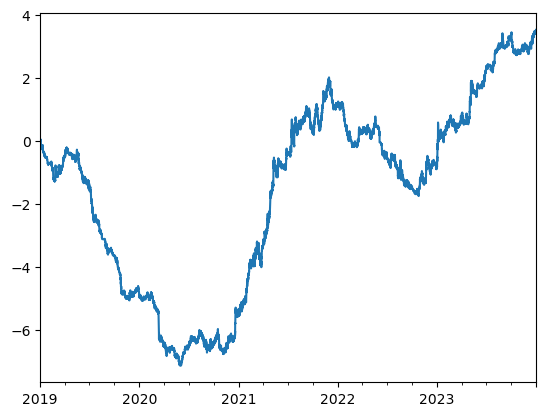

In [33]:
util.to_sharpe(port, in_sample_ret, plot = True, to_off=True)